<a href="https://colab.research.google.com/github/NINGTANG1124/UPF-HFI/blob/main/notebooks/final_model_chinese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect to googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 合并 HFI 到建模数据表

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 120)

# 读取
survey_df = pd.read_excel( "/content/drive/MyDrive/UPF-HFI/Model/outcome/survey_with_HFI.xlsx")
df_upf    = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx")

In [3]:
# ==== 2. 先检查 ====
issues = []

# 检查关键列
for col in ["UserID_clean", "HFI_binary", "HFI_raw_score"]:
    if col not in survey_df.columns:
        issues.append(f"survey 缺少 {col}")

for col in ["UserID_clean", "weighted_upf_percent"]:
    if col not in df_upf.columns:
        issues.append(f"upf 缺少 {col}")

# 检查 ID 是否有缺失/重复
for name, df in [("survey", survey_df), ("upf", df_upf)]:
    n_na = df["UserID_clean"].isna().sum()
    n_dup = df["UserID_clean"].duplicated().sum()
    if n_na:  issues.append(f"{name} 的 UserID_clean 有 {n_na} 个缺失")
    if n_dup: issues.append(f"{name} 的 UserID_clean 有 {n_dup} 个重复")

# 检查 upf_percent 是否数值
bad_upf = pd.to_numeric(df_upf["weighted_upf_percent"], errors="coerce").isna().sum()
if bad_upf:
    issues.append(f"weighted_upf_percent 有 {bad_upf} 个非数值/缺失")

# 打印检查结果
if issues:
    print("检查发现以下问题：")
    for i, msg in enumerate(issues, 1):
        print(f"{i}. {msg}")
else:
    print("没有发现问题，可以直接处理")


没有发现问题，可以直接处理


In [4]:
# ==== 检查关键变量缺失情况 ====
check_cols = ["HFI_binary", "weighted_upf_percent"]
missing_info = {}

for col in check_cols:
    if col not in survey_df.columns and col not in df_upf.columns:
        print(f"数据中找不到列: {col}")
        continue

    if col in survey_df.columns:
        n_miss = survey_df[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 survey_df 中缺失 {n_miss} 行")

    if col in df_upf.columns:
        n_miss = df_upf[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 upf_df 中缺失 {n_miss} 行")

# ==== 判断是否需要处理 ====
if all(v == 0 for v in missing_info.values()):
    print("两列都没有缺失，可以直接进入合并/建模")
else:
    print("存在缺失，需要处理后再合并")


HFI_binary 在 survey_df 中缺失 18 行
weighted_upf_percent 在 upf_df 中缺失 0 行
存在缺失，需要处理后再合并


In [5]:
# 1. 合并 survey 和 upf
df_model = pd.merge(survey_df, df_upf, on="UserID_clean", how="inner")

# 2. 删掉 HFI_binary 缺失的
df_model = df_model.dropna(subset=["HFI_binary"])

print("合并后样本量：", len(df_model))


合并后样本量： 308


In [6]:
# 导出合并后的数据
df_model.to_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx", index=False)

print("已导出到 /content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx")


已导出到 /content/drive/MyDrive/UPF-HFI/Model/outcome/merged_model.xlsx


# 0. 准备：工具函数

In [7]:
# =============================================
# ============  Imports & Settings  ============
# =============================================
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)

# ------------------------------------------------
# ----- 正态分位工具（SciPy优先，内置做后备） -----
# ------------------------------------------------
try:
    from scipy.stats import norm as _norm
    def _zcrit(alpha=0.05):   # 双侧 alpha -> z*
        return _norm.ppf(1 - alpha/2)
    def _cdf(x):
        return _norm.cdf(x)
except Exception:
    from statistics import NormalDist
    _nd = NormalDist()
    def _zcrit(alpha=0.05):
        return _nd.inv_cdf(1 - alpha/2)
    def _cdf(x):
        return _nd.cdf(x)

# --------------------------------
# ----- OLS 拟合（稳健方差） -----
# --------------------------------
def fit_ols(formula, data, cov_type="HC3"):
    """
    OLS 拟合 + 稳健标准误（默认 HC3）
    返回：robust 结果对象
    """
    model = smf.ols(formula, data=data).fit()
    if cov_type:
        model = model.get_robustcov_results(cov_type=cov_type)
    return model

# ----------------------------------------------------------
# ----- 统一结果取值（兼容 ndarray / pandas.Series） -----
# ----------------------------------------------------------
def _names_params_bse_p(res):
    """
    统一把 params/bse/pvalues 取成 Series，并带上模型列名。
    无论 statsmodels 返回 ndarray 还是 Series 都能兼容。
    """
    names   = list(res.model.exog_names)
    params  = pd.Series(np.asarray(res.params).ravel(),  index=names)
    bse     = pd.Series(np.asarray(res.bse).ravel(),     index=names)
    pvalues = pd.Series(np.asarray(res.pvalues).ravel(), index=names)
    return names, params, bse, pvalues

def get_term(result, term, default=np.nan):
    """安全获取某个项的系数（不存在则给默认值）。"""
    _, params, _, _ = _names_params_bse_p(result)
    return params.get(term, default)

# ------------------------------------------------------------
# ----- 置信区间 / 线性组合（边际效应）/ 交互整体检验 -----
# ------------------------------------------------------------
def coef_ci(result, term, alpha=0.05):
    """
    取指定项的点估计、95%CI 和 p 值；若项不存在返回 None
    """
    names, params, bse, pvalues = _names_params_bse_p(result)
    if term not in params.index:
        return None
    est = params[term]
    se  = bse[term]
    z   = _zcrit(alpha)
    ci  = (est - z*se, est + z*se)
    return est, ci, pvalues[term]

def linear_combo(result, combo):
    """
    线性组合估计（用于交互项下的 HFI 边际效应等）
    combo 例子：
      {'HFI_binary':1,
       "HFI_binary:C(ethn_participant, Treatment(reference='White'))[T.Asian]":1}
    返回：(点估计, 95%CI, p 值)
    """
    names, params, _, _ = _names_params_bse_p(result)
    cov = np.asarray(result.cov_params())
    w = np.zeros(len(names))
    for k, v in combo.items():
        if k in names:
            w[names.index(k)] = v
    est = float(np.dot(w, params.values))
    var = float(np.dot(w, np.dot(cov, w)))
    se  = np.sqrt(var)
    if se > 0:
        zval = est / se
        ci   = (est - _zcrit(0.05)*se, est + _zcrit(0.05)*se)
        p    = 2 * (1 - _cdf(abs(zval)))
    else:
        ci, p = (np.nan, np.nan), np.nan
    return est, ci, p

def joint_test_interaction(result, prefix):
    """
    交互整体检验：检验所有以 prefix 开头的系数为 0
    例如 prefix = "HFI_binary:C(ethn_participant, Treatment(reference='White'))"
    """
    names, params, _, _ = _names_params_bse_p(result)
    terms = [nm for nm in names if nm.startswith(prefix)]
    if not terms:
        return np.nan
    R = np.zeros((len(terms), len(names)))
    for i, t in enumerate(terms):
        R[i, names.index(t)] = 1.0
    ft = result.f_test(R)
    return float(np.asarray(ft.pvalue))

# -------------------------
# ----- 绘图（coefplot） -----
# -------------------------
def coefplot(ax, labels, est, lo, hi, title, xlabel="Coefficient (pp)"):
    """
    系数图（点 + 95%CI）
    labels: y 轴标签列表
    est/lo/hi: 对应点估计与置信区间上下界的等长列表
    """
    y = np.arange(len(labels))
    ax.errorbar(est, y, xerr=[est-lo, hi-est], fmt='o', capsize=4)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.axvline(0, linestyle='--', linewidth=1)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.invert_yaxis()


# 1. 族裔合并

In [8]:
assert "ethn_participant" in df_model.columns, "未找到 ethn_participant 列（应为1–9编码）。"

# 备份原始九类编码
df_model = df_model.copy()
df_model.rename(columns={"ethn_participant": "ethn_participant_raw"}, inplace=True)

# 强制转换为整数编码，兼容缺失
codes = pd.to_numeric(df_model["ethn_participant_raw"], errors="coerce").astype("Int64")

# 映射到三大类
code_to_ethn3 = {
    1: "White", 2: "White",
    3: "Asian", 4: "Asian", 5: "Asian", 6: "Asian",
    7: "All other ethnicities", 8: "All other ethnicities", 9: "All other ethnicities"
}
df_model["ethn_participant"] = codes.map(code_to_ethn3)

# 设定为分类变量并固定顺序（参考组=White）
df_model["ethn_participant"] = pd.Categorical(
    df_model["ethn_participant"],
    categories=["White", "Asian", "All other ethnicities"],
    ordered=False
)

# 健诊：展示原始九类分布与三类分布
print("原始九类（1–9）计数：")
print(codes.value_counts(dropna=False).sort_index())
print("\n合并后三类计数（含缺失）：")
print(df_model["ethn_participant"].value_counts(dropna=False))

# 若存在异常编码（非1–9），提示但不报错
invalid = codes[~codes.isin(list(range(1,10))) & codes.notna()].unique()
if len(invalid) > 0:
    print(f"\n[提示] 发现非常规族裔编码：{list(invalid)}；已在合并后记为缺失。")

原始九类（1–9）计数：
ethn_participant_raw
1    156
2     13
3     76
4     10
5      8
6      6
7     33
8      4
9      2
Name: count, dtype: Int64

合并后三类计数（含缺失）：
ethn_participant
White                    169
Asian                    100
All other ethnicities     39
Name: count, dtype: int64


In [10]:
OUTCOME = "weighted_upf_percent"
assert OUTCOME in df_model.columns


# 2. Core-A 主模型（不含 SES）

In [13]:
# ===== 2. Core-A 主模型（不含 SES）— 精简稳健版 =====
import numpy as np
import pandas as pd

coreA_cols = [OUTCOME, "HFI_binary", "age_participant",
              "gender_participant", "ethn_participant", "child_numbers"]

# 1) 构造分析集 + 基本体检
df_all = df_model[coreA_cols].copy()

# 目标变量合法范围（0–100）
y_bad_mask = ~pd.to_numeric(df_all[OUTCOME], errors="coerce").between(0, 100)
bad = int(y_bad_mask.sum())
if bad:
    print(f"[警告] {OUTCOME} 有 {bad} 条不在 0–100，将置为缺失。")
    df_all.loc[y_bad_mask, OUTCOME] = np.nan

# 数值化（防止字符串混入）
for col in ["child_numbers", "age_participant", "HFI_binary"]:
    df_all[col] = pd.to_numeric(df_all[col], errors="coerce")

# 丢失追踪
mask_keep = df_all.notna().all(axis=1)
dat_coreA   = df_all.loc[mask_keep].copy()
dropped_coreA = df_all.loc[~mask_keep].copy()

print(f"Core-A 保留样本: {len(dat_coreA)}")
print(f"Core-A 剔除样本: {len(dropped_coreA)}")
print("\n每个变量的缺失计数（降序）:")
print(df_all.isna().sum().sort_values(ascending=False))

# 2) 指定基准并拟合（HC3 稳健 SE）
form_coreA = (
    f"{OUTCOME} ~ HFI_binary"
    " + age_participant"
    " + C(gender_participant, Treatment(reference=1))"            # 1 = Male 作为基准
    " + C(ethn_participant, Treatment(reference='White'))"         # White 作为基准
    " + child_numbers"
)

res_coreA = fit_ols(form_coreA, dat_coreA, cov_type="HC3")

# 3) 报告主效应（HFI）
est, ci, p = coef_ci(res_coreA, "HFI_binary")
print(f"\nCore-A: HFI vs secure = {est:.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}); p={p:.3f}")

# （可选）partial R²
try:
    r2_hfi, p_wald = partial_R2(res_coreA, "HFI_binary")
    print(f"partial R² (HFI): {r2_hfi:.3f}（Wald p={p_wald:.3f}）")
except Exception:
    pass

Core-A 保留样本: 304
Core-A 剔除样本: 4

每个变量的缺失计数（降序）:
child_numbers           4
weighted_upf_percent    0
HFI_binary              0
age_participant         0
gender_participant      0
ethn_participant        0
dtype: int64

Core-A: HFI vs secure = 2.32 pp (95%CI -0.72, 5.37); p=0.136


/tmp/ipython-input-2893052603.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hfi_idx = int(np.where(df["term"].values=="HFI_binary")[0])


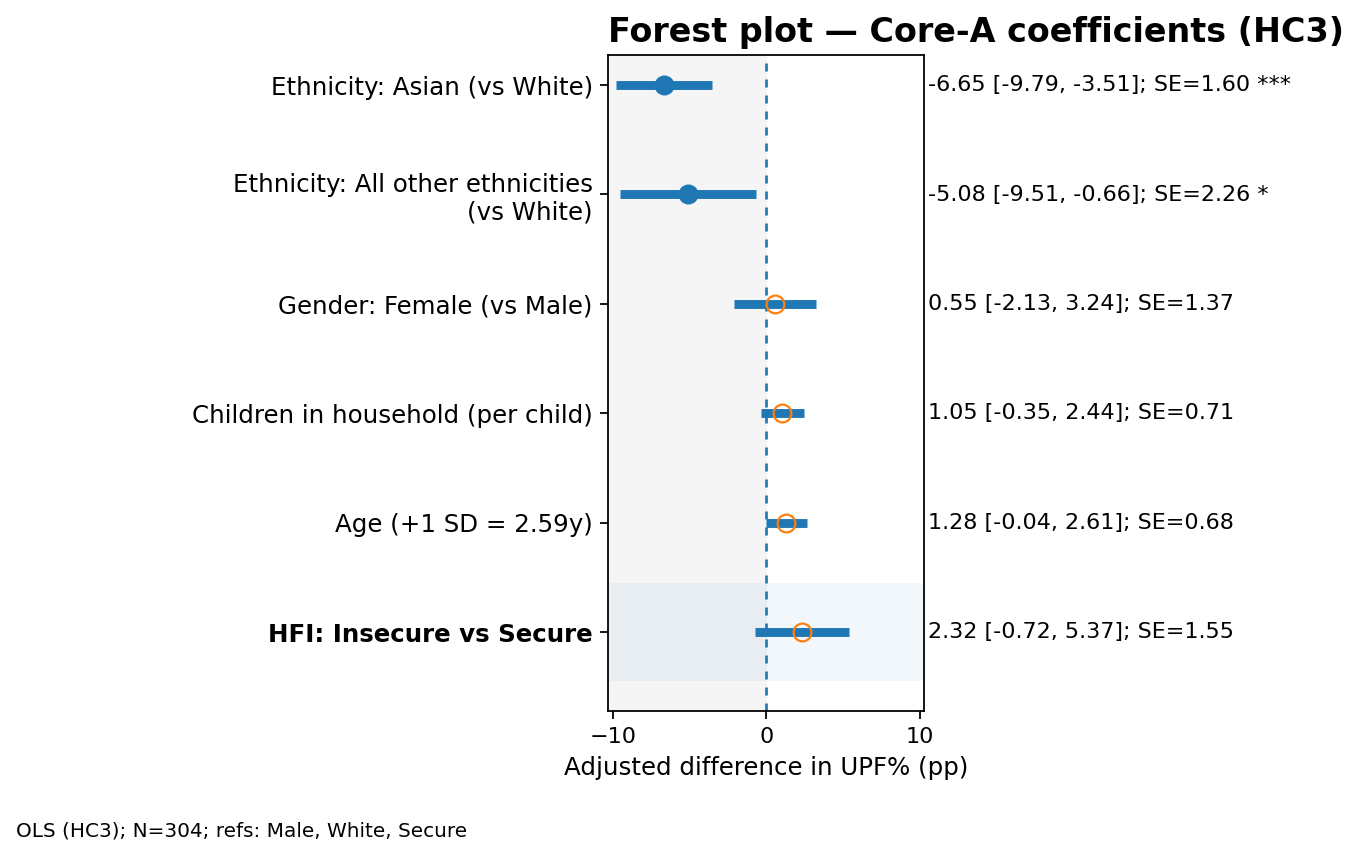

Saved: /content/drive/MyDrive/UPF-HFI/outcome_figure/forest_coreA.png


In [14]:
# =========================================================
# ============ 美化版 Forest Plot — Core-A (HC3) ==========
# =========================================================
import re, textwrap
import numpy as np
import matplotlib.pyplot as plt

show_age_per_sd = True      # 若想显示“每 +1SD”，置 True；否则按每年
gender_map = {1:"Male", 2:"Female", 3:"Other"}  # 你给定的性别口径

# 取系数/区间/显著性
try:
    z = _zcrit(0.05)
except NameError:
    z = 1.95996398454

names  = list(res_coreA.model.exog_names)
params = pd.Series(np.asarray(res_coreA.params).ravel(),  index=names)
bse    = pd.Series(np.asarray(res_coreA.bse).ravel(),     index=names)
pvals  = pd.Series(np.asarray(res_coreA.pvalues).ravel(), index=names)

# ==== 修改①：构建 df 时加入 se 列（后面要缩放） ====
df = pd.DataFrame({
    "term": names,
    "b":   params.values,
    "se":  bse.values,                                # <-- 新增
    "lo":  (params - z*bse).values,
    "hi":  (params + z*bse).values,
    "p":   pvals.values
})

# 仅保留关心的项
keep = (
    (df.term=="HFI_binary") |
    (df.term=="age_participant") |
    (df.term=="child_numbers") |
    (df.term.str.startswith("C(gender_participant")) |
    (df.term.str.startswith("C(ethn_participant"))
)
df = df.loc[keep].copy()

# ==== 修改②：年龄换算为 +1SD（连同 se 一起缩放） ====
if show_age_per_sd and "age_participant" in df.term.values:
    sd_age = float(dat_coreA["age_participant"].astype(float).std())
    idx = df.term=="age_participant"
    df.loc[idx, ["b","lo","hi","se"]] = (
        df.loc[idx, ["b","lo","hi","se"]].to_numpy() * sd_age
    )
    age_label = f"Age (+1 SD = {sd_age:.2f}y)"
else:
    age_label = "Age (per year)"

# ---------- 2) 生成可读标签 ----------
def label(term: str) -> str:
    if term=="HFI_binary": return "HFI: Insecure vs Secure"
    if term=="age_participant": return age_label
    if term=="child_numbers": return "Children in household (per child)"
    mg = re.match(r"C\(gender_participant.*\)\[T\.(.+)\]", term)
    if mg:
        code = mg.group(1)
        name = gender_map.get(code, gender_map.get(int(code), code))
        return f"Gender: {name} (vs Male)"
    me = re.match(r"C\(ethn_participant.*\)\[T\.(.+)\]", term)
    if me:
        v = me.group(1).strip()
        return f"Ethnicity: {v} (vs White)"
    return term

df["label"] = df["term"].apply(label)
df["label_wrapped"] = df["label"].apply(lambda s: textwrap.fill(s, width=34))

# 排序：HFI → Age → Children → Gender → Ethnicity
order = ["HFI_binary","age_participant","child_numbers"]
order += sorted(df.loc[df.term.str.startswith("C(gender_participant"),"term"])
order += sorted(df.loc[df.term.str.startswith("C(ethn_participant"),"term"])
df = df.set_index("term").loc[order].reset_index()

# ---------- 3) 绘图（粗横条 + 显著=实心/不显著=空心） ----------
labels = df["label_wrapped"].tolist()
# 取数组
b, lo, hi, p = map(np.asarray, [df["b"], df["lo"], df["hi"], df["p"]])
se = np.asarray(df["se"])   # ← 新增：用于显示 SE（已随 +1SD 同步缩放）

# ==== 修改③：统一用 ypos，不再用 y ====
ypos = np.arange(len(labels))
sig = p < 0.05

fig_h = 3.6 + 0.35*len(labels)
fig, ax = plt.subplots(figsize=(9.5, fig_h), dpi=160)

# 自适应范围 + 0线/负区背景
pad = 1.05 * max(abs(np.nanmin(lo)), abs(np.nanmax(hi)))
ax.set_xlim(-pad, pad)
ax.axvline(0, ls=(0,(3,3)), lw=1.2, zorder=1)
ax.axvspan(-pad, 0, color="0.96", zorder=0)

# 95%CI 粗横条 + 点（显著实心/不显著空心）
for yi, (loi, hii) in enumerate(zip(lo, hi)):
    ax.hlines(yi, xmin=loi, xmax=hii, lw=4.0, zorder=2)
ax.plot(b[sig],  ypos[sig],  "o", ms=8, zorder=3)
ax.plot(b[~sig], ypos[~sig], "o", ms=8, mfc="none", zorder=3)

# 轴与标签
ax.set_yticks(ypos); ax.set_yticklabels(labels, fontsize=11)
ax.set_xlabel("Adjusted difference in UPF% (pp)", fontsize=11)

# 右侧标注“点估计 [CI]”
def stars(pv): return "***" if pv<1e-3 else "**" if pv<1e-2 else "*" if pv<0.05 else ""
for yi, (bi, loi, hii, pi, sei) in enumerate(zip(b, lo, hi, p, se)):   # ← 加 se
    ax.text(1.01, yi, f"{bi:.2f} [{loi:.2f}, {hii:.2f}]; SE={sei:.2f} {stars(pi)}",
            transform=ax.get_yaxis_transform(), ha="left", va="center", fontsize=10)

# 高亮 HFI 行
if "HFI_binary" in df["term"].values:
    hfi_idx = int(np.where(df["term"].values=="HFI_binary")[0])
    ax.axhspan(hfi_idx-0.45, hfi_idx+0.45, alpha=0.06, zorder=0)
    ax.get_yticklabels()[hfi_idx].set_fontweight("bold")

ax.set_title("Forest plot — Core-A coefficients (HC3)", loc="left", fontsize=15, weight="bold", pad=6)
fig.text(0.12, 0.02, f"OLS (HC3); N={len(dat_coreA)}; refs: Male, White, Secure",
         ha="left", va="bottom", fontsize=9)

plt.tight_layout(rect=[0.22, 0.06, 0.98, 0.95])

# 保存/显示
out = "/content/drive/MyDrive/UPF-HFI/outcome_figure/forest_coreA.png"   # 可改路径
plt.savefig(out, dpi=300, bbox_inches="tight")
plt.show(); plt.close(fig)
print("Saved:", out)


# 3. Core-B 交互（HFI × 族裔三类；参考White）

In [15]:
# ===== 3. Core-B 交互（HFI × 族裔三类；参考 White）— 稳健版 =====
need_cols_B = [OUTCOME, "HFI_binary", "age_participant",
               "gender_participant", "ethn_participant", "child_numbers"]

dat_coreB = df_model[need_cols_B].copy()
for col in ["age_participant", "child_numbers", "HFI_binary"]:
    dat_coreB[col] = pd.to_numeric(dat_coreB[col], errors="coerce")
dat_coreB = dat_coreB.dropna().copy()

print(f"Core-B 样本量: {len(dat_coreB)}")

form_coreB = (
    f"{OUTCOME} ~ HFI_binary"
    " + age_participant"
    " + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
    " + HFI_binary:C(ethn_participant, Treatment(reference='White'))"
)
res_coreB = fit_ols(form_coreB, dat_coreB, cov_type="HC3")

groups = ["White", "Asian", "All other ethnicities"]

def _find_inter_name(result, group_label: str):
    """在模型里找到对应族裔的交互项名；若不存在返回 None。"""
    names = list(getattr(result.model, "exog_names", []))
    suf = f"[T.{group_label}]"
    for nm in names:
        if nm.startswith("HFI_binary:C(ethn_participant") and nm.endswith(suf):
            return nm
    return None

rows = []
for g in groups:
    combo = {"HFI_binary": 1.0}
    if g != "White":
        key = _find_inter_name(res_coreB, g)
        if key is None:
            print(f"[警告] 未找到 {g} 的交互项，可能该水平在样本中缺失。")
        else:
            combo[key] = 1.0
    est, ci, p = linear_combo(res_coreB, combo)
    lo, hi = ci
    rows.append({"group": g, "d": est, "lo": lo, "hi": hi, "p": p})

effects_df = pd.DataFrame(rows)
p_inter = joint_test_interaction(res_coreB, "HFI_binary:C(ethn_participant, Treatment(reference='White'))")

# 漂亮地打印
print("\nEthnicity-specific ΔUPF (insecure − secure):")
for r in effects_df.itertuples():
    sig = "*" if r.p < 0.05 else ""
    print(f"  {r.group:>22}: {r.d:+.2f} pp [{r.lo:.2f}, {r.hi:.2f}]  p={r.p:.3f}{sig}")
print(f"\nOverall interaction test: p-interaction = {p_inter:.3f}")

# 组内 n 与导出
n_by_grp = dat_coreB.groupby("ethn_participant")["HFI_binary"].size()
effects_df["n"] = effects_df["group"].map(n_by_grp.to_dict())
effects_df.to_csv("/content/drive/MyDrive/UPF-HFI/outcome_figure/coreB_ethnicity_effects.csv", index=False)
print("Saved: /content/drive/MyDrive/UPF-HFI/outcome_figure/coreB_ethnicity_effects.csv")


Core-B 样本量: 304

Ethnicity-specific ΔUPF (insecure − secure):
                   White: +0.99 pp [-3.23, 5.22]  p=0.644
                   Asian: +2.16 pp [-2.92, 7.25]  p=0.404
   All other ethnicities: +7.48 pp [-0.94, 15.90]  p=0.082

Overall interaction test: p-interaction = 0.405


/tmp/ipython-input-767345847.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n_by_grp = dat_coreB.groupby("ethn_participant")["HFI_binary"].size()


Saved: /content/drive/MyDrive/UPF-HFI/outcome_figure/coreB_ethnicity_effects.csv


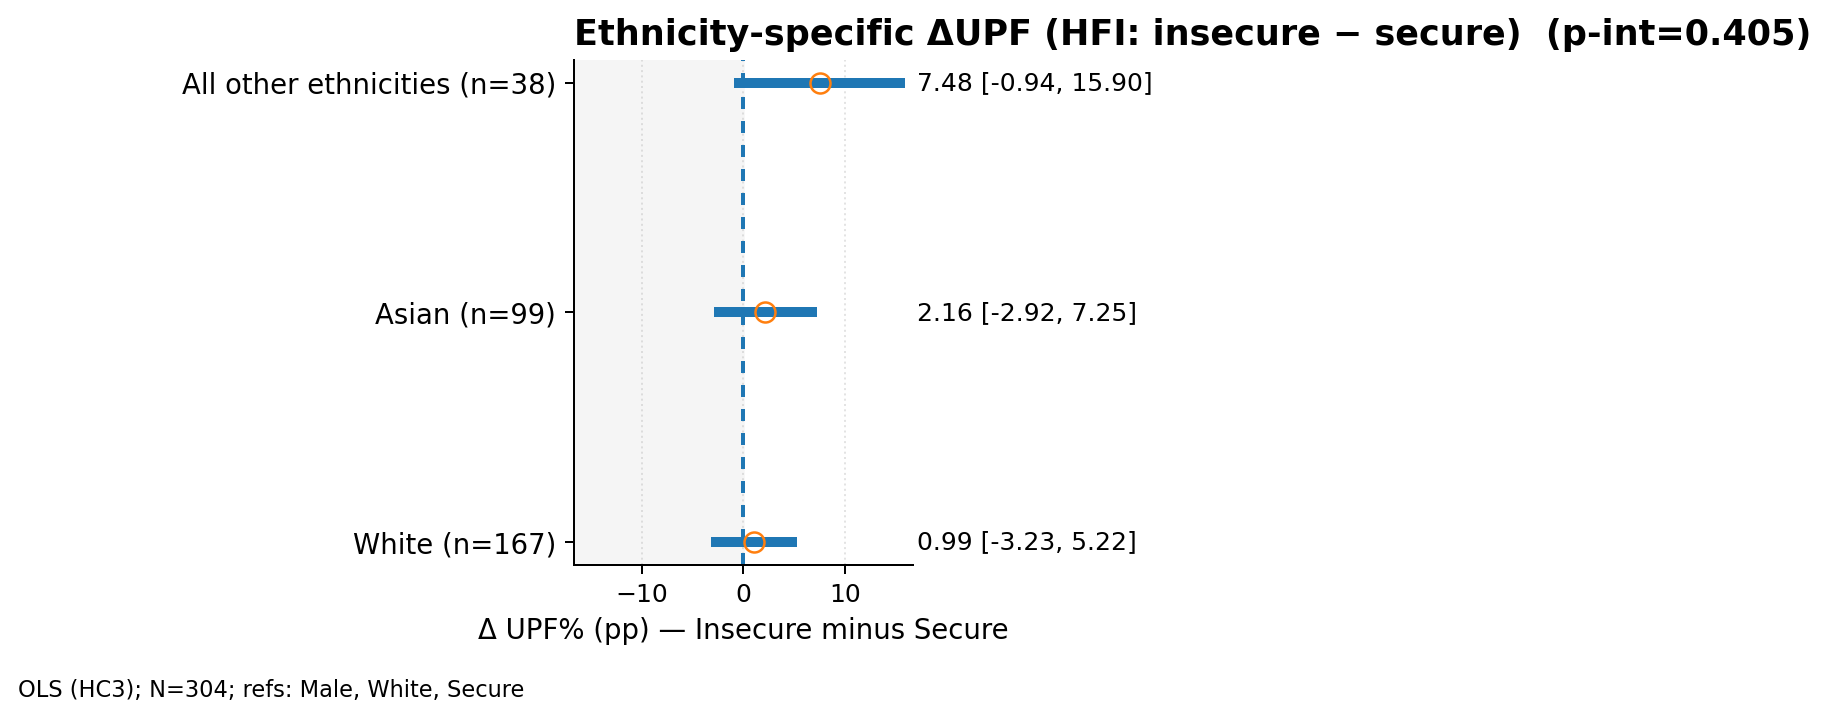

Saved: /content/drive/MyDrive/UPF-HFI/outcome_figure/coreB_ethnicity_dUPF.png


In [16]:
# === Figure: ΔUPF by Ethnicity (HFI insecure − secure), with 95% CI ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 若上一块已生成 effects_df，这里直接复用；否则请先运行上一块
df_eff = effects_df.copy()

# 固定顺序 & 标签加 n
order = ["White", "Asian", "All other ethnicities"]
df_eff["n"] = df_eff["n"].fillna(0).astype(int)
df_eff["label"] = df_eff.apply(lambda r: f"{r['group']} (n={r['n']})", axis=1)
df_eff = df_eff.set_index("group").loc[order].reset_index()

# 画图：粗横条 + 实心/空心点；对称坐标 + 加粗零线
ypos = np.arange(len(df_eff))
sig  = df_eff["p"].values < 0.05

fig_h = 3.2 + 0.35 * len(df_eff)
fig, ax = plt.subplots(figsize=(7.6, fig_h), dpi=180)

# 95% CI 横条
for i, (lo, hi) in enumerate(zip(df_eff["lo"], df_eff["hi"])):
    ax.hlines(ypos[i], xmin=lo, xmax=hi, lw=4.0, zorder=2)

# 点：显著=实心，不显著=空心
ax.plot(df_eff["d"].values[sig],  ypos[sig],  "o", ms=8, zorder=3)
ax.plot(df_eff["d"].values[~sig], ypos[~sig], "o", ms=8, mfc="none", zorder=3)

# 轴 & 0 线 & 对称范围
mx = 1.05 * max(abs(df_eff["lo"].min()), abs(df_eff["hi"].max()))
ax.set_xlim(-mx, mx)
ax.axvspan(-mx, 0, color="0.96", zorder=0)
ax.axvline(0, ls=(0,(3,3)), lw=1.6)

ax.set_yticks(ypos); ax.set_yticklabels(df_eff["label"], fontsize=11)
ax.set_xlabel("Δ UPF% (pp) — Insecure minus Secure", fontsize=11)

# 右侧数值+星号
def stars(pv): return "***" if pv<1e-3 else "**" if pv<1e-2 else "*" if pv<0.05 else ""
for yi, r in enumerate(df_eff.itertuples()):
    ax.text(1.01, yi, f"{r.d:.2f} [{r.lo:.2f}, {r.hi:.2f}] {stars(r.p)}",
            transform=ax.get_yaxis_transform(), ha="left", va="center", fontsize=10)

# 标题含 p-interaction；图注含 N 与参考组
title = f"Ethnicity-specific ΔUPF (HFI: insecure − secure)  (p-int={p_inter:.3f})"
ax.set_title(title, loc="left", fontsize=14, weight="bold", pad=6)
fig.text(0.12, 0.02, f"OLS (HC3); N={len(dat_coreB)}; refs: Male, White, Secure", ha="left", va="bottom", fontsize=9)

# 美化与保存
ax.grid(axis='x', ls=':', alpha=0.35)
ax.spines[['top','right']].set_visible(False)
plt.tight_layout(rect=[0.22, 0.06, 0.98, 0.95])

Path("output").mkdir(exist_ok=True)
plt.savefig("/content/drive/MyDrive/UPF-HFI/outcome_figure/coreB_ethnicity_dUPF.png", dpi=300, bbox_inches="tight")
plt.show(); plt.close(fig)
print("Saved: /content/drive/MyDrive/UPF-HFI/outcome_figure/coreB_ethnicity_dUPF.png")

# 4. Robustness（结构性混杂）：一次性加入 SES（income, employ）

In [17]:
# ===== Robustness: add SES once (same-N), print only =====
import numpy as np, pandas as pd

# 同一样本（用于 Core-A 与 +SES 两个模型的严格对比）
ses_cols = [OUTCOME, "HFI_binary", "age_participant",
            "gender_participant", "ethn_participant", "child_numbers",
            "income", "employ"]
dat_R = df_model[ses_cols].copy()
for col in ["HFI_binary","age_participant","child_numbers","income"]:
    dat_R[col] = pd.to_numeric(dat_R[col], errors="coerce")
dat_R = dat_R.dropna().copy()

print(f"\nRobustness(+SES) 样本量（same-N）: {len(dat_R)}")

# 两个模型都基于同一个 dat_R
res_coreA_sameN = fit_ols(
    f"{OUTCOME} ~ HFI_binary + age_participant"
    " + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers",
    dat_R, cov_type="HC3"
)
res_ses = fit_ols(
    f"{OUTCOME} ~ HFI_binary + age_participant"
    " + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers + income + C(employ)",
    dat_R, cov_type="HC3"
)

# 取系数与区间
b_core, ci_core, p_core = coef_ci(res_coreA_sameN, "HFI_binary")
b_ses , ci_ses , p_ses  = coef_ci(res_ses,          "HFI_binary")

# 增减比例（b_core 的相对变化）
atten = np.nan
if pd.notna(b_core) and not np.isclose(b_core, 0.0):
    atten = 100.0 * (b_core - b_ses) / abs(b_core)
chg = "attenuation" if atten >= 0 else "increase"

print(f"HFI: Core-A = {b_core:.2f} pp [ {ci_core[0]:.2f}, {ci_core[1]:.2f} ] (p={p_core:.3f})")
print(f"     +SES    = {b_ses:.2f} pp [ {ci_ses[0]:.2f}, {ci_ses[1]:.2f} ] (p={p_ses:.3f})")
print(f"Δ = {b_ses-b_core:+.2f} pp  ({chg} {abs(atten):.1f}%)  — Same sample N={len(dat_R)}; OLS(HC3)")

# 可选：报告 HFI 的 partial R²（若你已引入 partial_R2 工具函数）
try:
    r2_core, pF_core = partial_R2(res_coreA_sameN, "HFI_binary")
    r2_ses , pF_ses  = partial_R2(res_ses,          "HFI_binary")
    print(f"partial R²(HFI): Core-A {r2_core:.3f} (p={pF_core:.3f}) → +SES {r2_ses:.3f} (p={pF_ses:.3f})")
except Exception:
    pass

# 若想导出到表格：
out_tab = pd.DataFrame({
    "model":["Core-A","Core-A + SES"],
    "beta":[b_core, b_ses],
    "ci_lo":[ci_core[0], ci_ses[0]],
    "ci_hi":[ci_core[1], ci_ses[1]],
    "p":[p_core, p_ses],
    "N":len(dat_R)
})
out_tab.to_csv("output/robustness_ses_sameN.csv", index=False)
print("Saved: output/robustness_ses_sameN.csv")



Robustness(+SES) 样本量（same-N）: 299
HFI: Core-A = 2.75 pp [ -0.30, 5.80 ] (p=0.078)
     +SES    = 3.34 pp [ 0.04, 6.64 ] (p=0.048)
Δ = +0.59 pp  (increase 21.3%)  — Same sample N=299; OLS(HC3)
Saved: output/robustness_ses_sameN.csv


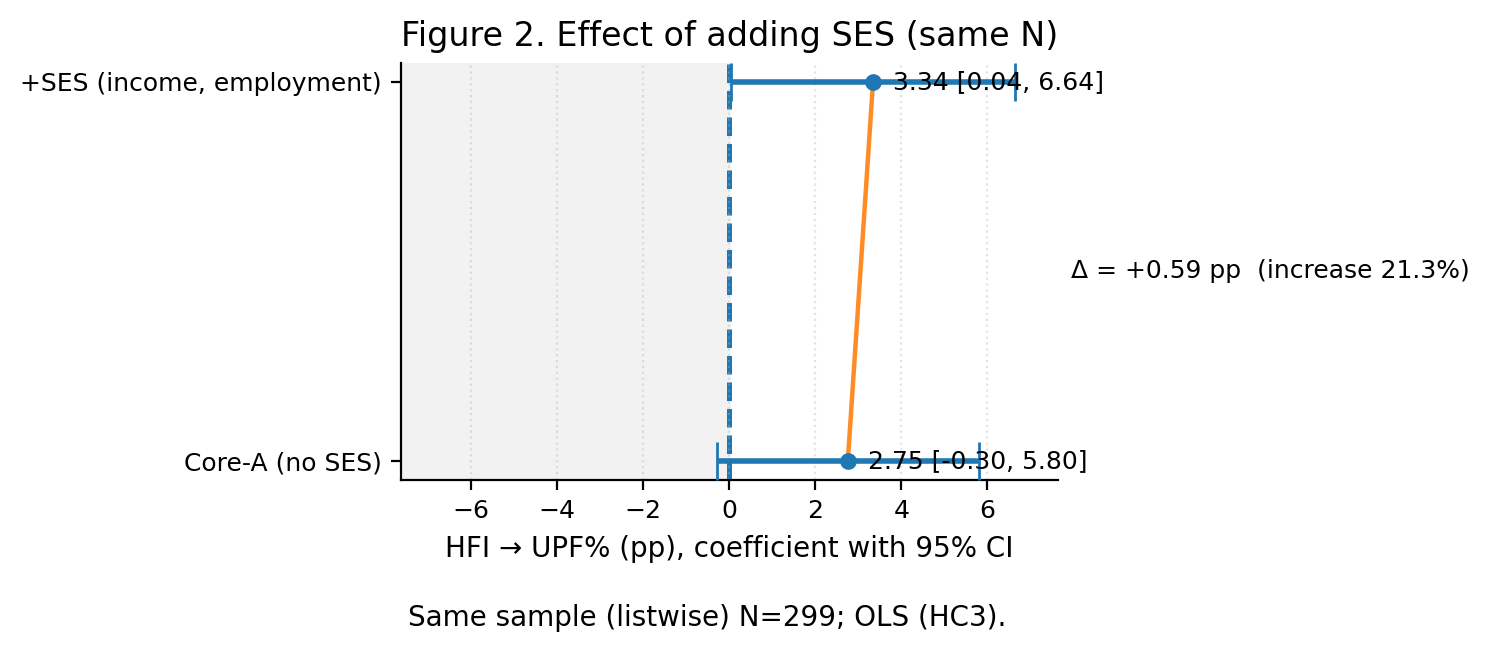

In [18]:
# ===== Figure 2. Effect of adding SES (same N) =====
import numpy as np, matplotlib.pyplot as plt

labels = ["Core-A (no SES)", "+SES (income, employment)"]
b  = np.array([b_core, b_ses], dtype=float)
lo = np.array([ci_core[0], ci_ses[0]], dtype=float)
hi = np.array([ci_core[1], ci_ses[1]], dtype=float)
err = np.vstack([b - lo, hi - b])

plt.rcParams.update({
    "axes.titlesize": 12, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
})

fig, ax = plt.subplots(figsize=(7.6, 3.6), dpi=200)
ypos = np.arange(2)

# 横轴范围 & 底色
mx = float(np.max(np.abs(np.r_[lo, hi])))
ax.set_xlim(-1.15*mx, 1.15*mx)
ax.axvspan(-1.15*mx, 0, color="0.95", zorder=0)   # 负区浅底
ax.axvline(0, linestyle='--', linewidth=1.8, zorder=1)

# 误差线 + 点 + 连接线
ax.errorbar(b, ypos, xerr=err, fmt='o', capsize=7, elinewidth=2, markersize=5, zorder=3)
ax.plot(b, ypos, linewidth=1.6, alpha=0.9, zorder=2)

# 轴标签
ax.set_yticks(ypos, labels)
ax.set_xlabel("HFI → UPF% (pp), coefficient with 95% CI")
ax.set_title("Figure 2. Effect of adding SES (same N)")

# 右侧文字（Δ 与增减比例）
delta = b[1] - b[0]
chg = "attenuation" if atten >= 0 else "increase"
ax.text(ax.get_xlim()[1] + 0.02*(ax.get_xlim()[1]-ax.get_xlim()[0]),
        0.5, f"Δ = {delta:+.2f} pp  ({chg} {abs(atten):.1f}%)",
        va='center', ha='left', fontsize=9, transform=ax.transData)

# 在点旁直接标注“估计 [CI]”
shift = 0.03 * (ax.get_xlim()[1]-ax.get_xlim()[0])
for i in range(2):
    ha = 'left' if b[i] >= 0 else 'right'
    x_text = b[i] + (shift if b[i] >= 0 else -shift)
    ax.text(x_text, ypos[i], f"{b[i]:.2f} [{lo[i]:.2f}, {hi[i]:.2f}]", va='center', ha=ha, fontsize=9)

ax.grid(axis='x', linestyle=':', alpha=0.35)
ax.text(0.01, -0.35, f"Same sample (listwise) N={len(dat_R)}; OLS (HC3).", transform=ax.transAxes)
ax.spines[['top','right']].set_visible(False)
plt.tight_layout()

# 若需要保存：
import pathlib; pathlib.Path("output").mkdir(exist_ok=True)
plt.savefig("output/figure2_ses_sameN.png", dpi=300, bbox_inches="tight")

plt.show()


## 对比

In [19]:
# ===== Robustness: add SES once — fresh-N (each model uses its own available rows) =====
import numpy as np, pandas as pd

# 1) 各自样本
coreA_cols_fresh = [OUTCOME, "HFI_binary", "age_participant",
                    "gender_participant", "ethn_participant", "child_numbers"]
ses_cols_fresh   = coreA_cols_fresh + ["income", "employ"]

dat_coreA_fresh = df_model[coreA_cols_fresh].copy()
for c in ["HFI_binary","age_participant","child_numbers"]:
    dat_coreA_fresh[c] = pd.to_numeric(dat_coreA_fresh[c], errors="coerce")
dat_coreA_fresh = dat_coreA_fresh.dropna().copy()

dat_ses_fresh = df_model[ses_cols_fresh].copy()
for c in ["HFI_binary","age_participant","child_numbers","income"]:
    dat_ses_fresh[c] = pd.to_numeric(dat_ses_fresh[c], errors="coerce")
dat_ses_fresh = dat_ses_fresh.dropna().copy()

print(f"Core-A fresh-N: N={len(dat_coreA_fresh)}")
print(f"+SES  fresh-N: N={len(dat_ses_fresh)}")

# 2) 拟合两个模型（各自 fresh-N）
form_core = (
    f"{OUTCOME} ~ HFI_binary + age_participant"
    " + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)
form_ses  = form_core + " + income + C(employ)"

res_core_fresh = fit_ols(form_core, dat_coreA_fresh, cov_type="HC3")
res_ses_fresh  = fit_ols(form_ses,  dat_ses_fresh,  cov_type="HC3")

# 3) 系数与区间
b_core_f, ci_core_f, p_core_f = coef_ci(res_core_fresh, "HFI_binary")
b_ses_f , ci_ses_f , p_ses_f  = coef_ci(res_ses_fresh,  "HFI_binary")

# 4) 变化幅度（fresh-N）
atten_f = np.nan
if pd.notna(b_core_f) and not np.isclose(b_core_f, 0.0):
    atten_f = 100.0 * (b_core_f - b_ses_f) / abs(b_core_f)
chg_f = "attenuation" if atten_f >= 0 else "increase"

print(f"HFI (fresh-N):")
print(f"  Core-A = {b_core_f:.2f} pp [{ci_core_f[0]:.2f}, {ci_core_f[1]:.2f}]  (p={p_core_f:.3f})")
print(f"  +SES   = {b_ses_f:.2f} pp [{ci_ses_f[0]:.2f}, {ci_ses_f[1]:.2f}]  (p={p_ses_f:.3f})")
print(f"  Δ = {b_ses_f-b_core_f:+.2f} pp  ({chg_f} {abs(atten_f):.1f}%)")

# 5) 与 same-N 的对比（如果前面变量在环境中）
try:
    _ = b_core  # same-N 变量是否存在
    print("\nCompare to same-N:")
    print(f"  Core-A: fresh − same = {b_core_f - b_core:+.2f} pp")
    print(f"  +SES  : fresh − same = {b_ses_f  - b_ses:+.2f} pp")
    print(f"  Δ(change due to SES): fresh − same = {(b_ses_f-b_core_f) - (b_ses-b_core):+.2f} pp")
except NameError:
    pass

# 可选：导出一张对比小表
out_tab_fresh = pd.DataFrame({
    "model":["Core-A (fresh)","+SES (fresh)"],
    "beta":[b_core_f, b_ses_f],
    "ci_lo":[ci_core_f[0], ci_ses_f[0]],
    "ci_hi":[ci_core_f[1], ci_ses_f[1]],
    "p":[p_core_f, p_ses_f],
    "N":[len(dat_coreA_fresh), len(dat_ses_fresh)]
})
out_tab_fresh.to_csv("output/robustness_ses_freshN.csv", index=False)
print("Saved: output/robustness_ses_freshN.csv")


Core-A fresh-N: N=304
+SES  fresh-N: N=299
HFI (fresh-N):
  Core-A = 2.32 pp [-0.72, 5.37]  (p=0.136)
  +SES   = 3.34 pp [0.04, 6.64]  (p=0.048)
  Δ = +1.02 pp  (increase 43.8%)

Compare to same-N:
  Core-A: fresh − same = -0.43 pp
  +SES  : fresh − same = +0.00 pp
  Δ(change due to SES): fresh − same = +0.43 pp
Saved: output/robustness_ses_freshN.csv


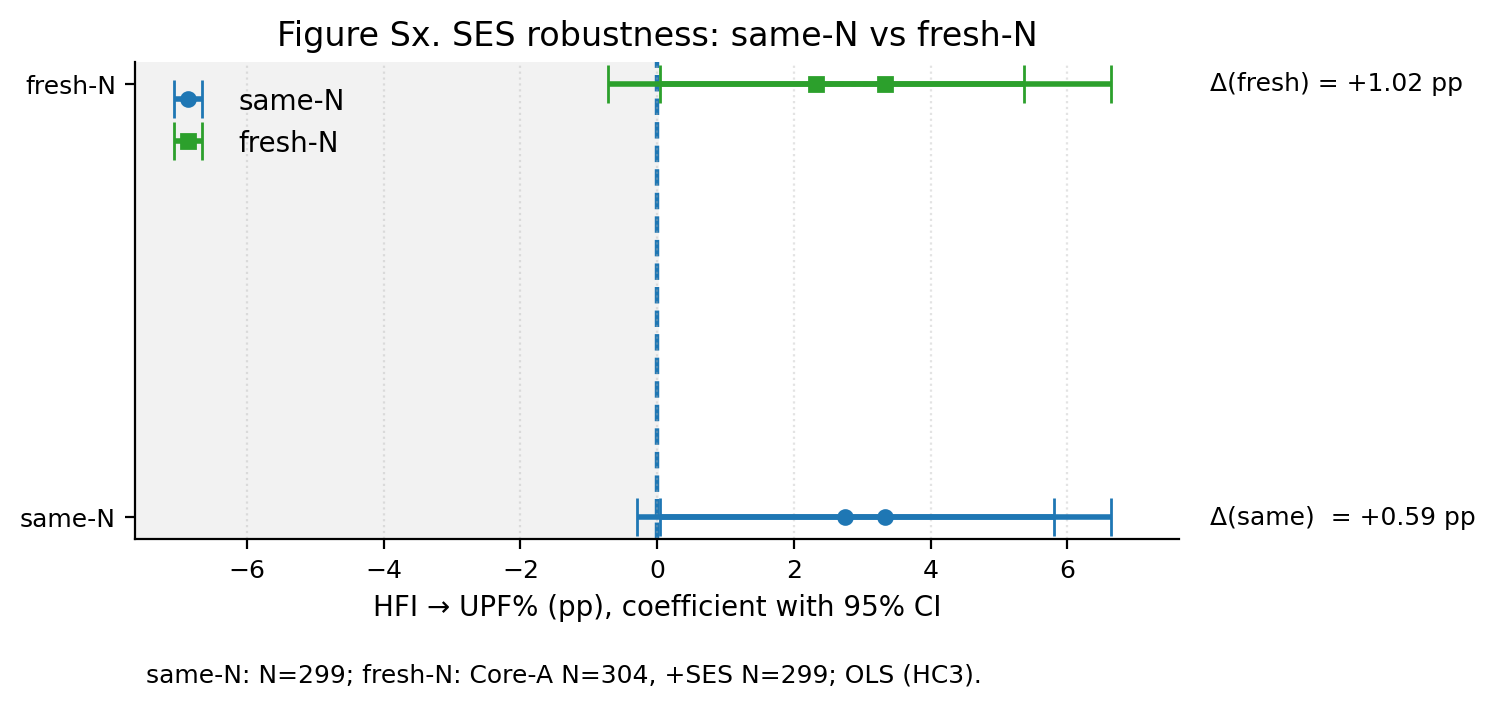

In [21]:
# ===== Figure Sx. +SES effect — same-N vs fresh-N (overlay dumbbells) =====
import numpy as np, matplotlib.pyplot as plt

# 需要：同一内核里已有 same-N 的 b_core, ci_core, b_ses, ci_ses, len(dat_R)
# 以及 fresh-N 的 b_core_f, ci_core_f, b_ses_f, ci_ses_f, len(dat_coreA_fresh), len(dat_ses_fresh)

# 统一横轴范围覆盖两套区间
all_bounds = np.array([ci_core[0], ci_core[1], ci_ses[0], ci_ses[1],
                       ci_core_f[0], ci_core_f[1], ci_ses_f[0], ci_ses_f[1]], float)
mx = float(np.max(np.abs(all_bounds))) * 1.15

fig, ax = plt.subplots(figsize=(7.6, 3.8), dpi=200)
ax.set_xlim(-mx, mx)
ax.axvspan(-mx, 0, color="0.95", zorder=0)
ax.axvline(0, ls='--', lw=1.6, zorder=1)

# y 位置：0 = same-N, 1 = fresh-N
ypos = np.array([0,1])

# same-N
b_same  = np.array([b_core,  b_ses ], float)
lo_same = np.array([ci_core[0], ci_ses[0]], float)
hi_same = np.array([ci_core[1], ci_ses[1]], float)
ax.errorbar(
    b_same,
    np.full(b_same.shape, ypos[0]),                   # ← 原来是 ypos[0]
    xerr=np.vstack([b_same-lo_same, hi_same-b_same]),
    fmt='o', capsize=7, elinewidth=2, markersize=5, label="same-N", zorder=3
)
ax.plot(b_same,  [ypos[0], ypos[0]], lw=1.6, alpha=0.9, zorder=2)

# fresh-N（不同点形+虚线连接）
b_fresh  = np.array([b_core_f, b_ses_f], float)
lo_fresh = np.array([ci_core_f[0], ci_ses_f[0]], float)
hi_fresh = np.array([ci_core_f[1], ci_ses_f[1]], float)
ax.errorbar(
    b_fresh,
    np.full(b_fresh.shape, ypos[1]),                  # ← 原来是 ypos[1]
    xerr=np.vstack([b_fresh-lo_fresh, hi_fresh-b_fresh]),
    fmt='s', capsize=7, elinewidth=2, markersize=5, label="fresh-N", zorder=3
)
ax.plot(b_fresh, [ypos[1], ypos[1]], lw=1.6, alpha=0.9, linestyle=':', zorder=2)

# 轴与标签
ax.set_yticks(ypos, ["same-N", "fresh-N"])
ax.set_xlabel("HFI → UPF% (pp), coefficient with 95% CI")
ax.set_title("Figure Sx. SES robustness: same-N vs fresh-N")

# 右侧写 Δ
shift = 0.03 * (ax.get_xlim()[1]-ax.get_xlim()[0])
ax.text(ax.get_xlim()[1] + shift, ypos[0], f"Δ(same)  = {b_same[1]-b_same[0]:+.2f} pp", va='center', ha='left', fontsize=9)
ax.text(ax.get_xlim()[1] + shift, ypos[1], f"Δ(fresh) = {b_fresh[1]-b_fresh[0]:+.2f} pp", va='center', ha='left', fontsize=9)

# 图注：两套样本量
ax.text(0.01, -0.30,
        f"same-N: N={len(dat_R)}; fresh-N: Core-A N={len(dat_coreA_fresh)}, +SES N={len(dat_ses_fresh)}; OLS (HC3).",
        transform=ax.transAxes, fontsize=9)

ax.legend(frameon=False, loc="upper left")
ax.grid(axis='x', ls=':', alpha=0.35)
ax.spines[['top','right']].set_visible(False)
plt.tight_layout()

# 保存（可选）
import pathlib; pathlib.Path('output').mkdir(exist_ok=True)
plt.savefig('output/figureSx_ses_same_vs_fresh.png', dpi=300, bbox_inches='tight')

plt.show()


In [22]:
# 1) 直接列出“缺 SES”的那几行的关键信息（case-centric）
miss = df_model[[OUTCOME,"HFI_binary","ethn_participant","gender_participant",
                 "age_participant","child_numbers","income","employ"]].copy()
miss = miss[miss["income"].isna() | miss["employ"].isna()]
print(len(miss))              # 应该是 5
print(miss[["HFI_binary","ethn_participant"]].value_counts())  # 谁占的多


5
HFI_binary  ethn_participant     
0.0         White                    3
1.0         Asian                    1
            All other ethnicities    1
Name: count, dtype: int64


# 5. Sensitivity（关键假设变化）

## 5.1 HFI 三分类(有序) + 趋势检验

In [23]:
# ===== Sensitivity: HFI 3-category + trend (print only) =====
import numpy as np, pandas as pd
from pandas.api.types import CategoricalDtype

if "HFI_category" in df_model.columns:
    # 统一类型与顺序
    ord_dtype = CategoricalDtype(
        categories=["Food secure","Low food security","Very low food security"], ordered=True
    )
    df_model["HFI_category"] = df_model["HFI_category"].astype(ord_dtype)

    # 同一套自变量 + 三分类列
    sens_cols = [OUTCOME, "HFI_binary", "age_participant",
                 "gender_participant", "ethn_participant", "child_numbers",
                 "HFI_category"]
    dat_sens = df_model[sens_cols].copy()
    # 强转为数值，防止混入字符串
    for col in ["HFI_binary","age_participant","child_numbers"]:
        dat_sens[col] = pd.to_numeric(dat_sens[col], errors="coerce")
    dat_sens = dat_sens.dropna().copy()

    print(f"\nSensitivity—有序三分类 样本量: {len(dat_sens)}")

    # (a) 类别模型（相对 Food secure）
    form_cat = (
        f"{OUTCOME} ~ C(HFI_category, Treatment(reference='Food secure'))"
        " + age_participant"
        " + C(gender_participant, Treatment(reference=1))"
        " + C(ethn_participant, Treatment(reference='White'))"
        " + child_numbers"
    )
    res_cat = fit_ols(form_cat, dat_sens, cov_type="HC3")

    print("\nAdjusted difference vs Food secure:")
    for lev in ["Low food security","Very low food security"]:
        term = f"C(HFI_category, Treatment(reference='Food secure'))[T.{lev}]"
        est, ci, p = coef_ci(res_cat, term)
        print(f"  {lev:>21}: {est:+.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}); p={p:.3f}")

    # (b) 趋势检验（0/1/2 连续）
    tr_map = {"Food secure":0, "Low food security":1, "Very low food security":2}
    dat_sens["HFI_trend"] = dat_sens["HFI_category"].map(tr_map).astype(float)

    form_trend = (
        f"{OUTCOME} ~ HFI_trend"
        " + age_participant"
        " + C(gender_participant, Treatment(reference=1))"
        " + C(ethn_participant, Treatment(reference='White'))"
        " + child_numbers"
    )
    res_trend = fit_ols(form_trend, dat_sens, cov_type="HC3")
    est, ci, p = coef_ci(res_trend, "HFI_trend")
    print(f"\np-trend: 每升一档 HFI，UPF% 变化 {est:.2f} pp (95%CI {ci[0]:.2f}, {ci[1]:.2f}); p={p:.3f}")

else:
    print("\n[跳过] 未找到 HFI_category（三分类）列，已跳过敏感性-三分类与趋势检验。")



Sensitivity—有序三分类 样本量: 304

Adjusted difference vs Food secure:
      Low food security: +0.87 pp (95%CI -3.11, 4.85); p=0.668
  Very low food security: +3.80 pp (95%CI -0.06, 7.65); p=0.055

p-trend: 每升一档 HFI，UPF% 变化 1.75 pp (95%CI -0.11, 3.60); p=0.066


In [24]:
# —— 共享：拟合类别模型 & 趋势模型，并做边际预测 ——
import numpy as np, pandas as pd
from pandas.api.types import CategoricalDtype

cats = ["Food secure","Low food security","Very low food security"]
df_model["HFI_category"] = df_model["HFI_category"].astype(
    CategoricalDtype(categories=cats, ordered=True)
)

sens_cols = [OUTCOME, "age_participant","gender_participant",
             "ethn_participant","child_numbers","HFI_category"]
dat = df_model[sens_cols].copy()
for c in ["age_participant","child_numbers"]:
    dat[c] = pd.to_numeric(dat[c], errors="coerce")
dat = dat.dropna().copy()

# 类别模型（相对 Food secure），与正文一致
form_cat = (
    f"{OUTCOME} ~ C(HFI_category, Treatment(reference='Food secure'))"
    " + age_participant + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White')) + child_numbers"
)
res_cat = fit_ols(form_cat, dat, cov_type="HC3")

# 典型协变量下的预测均值（每类一条）
grid = pd.DataFrame({
    "HFI_category": cats,
    "age_participant": dat["age_participant"].mean(),
    "gender_participant": 1,      # Male
    "ethn_participant": "White",
    "child_numbers": dat["child_numbers"].mean(),
})
sf    = res_cat.get_prediction(grid).summary_frame(alpha=0.05)
means = sf["mean"].to_numpy(float)
lo    = sf["mean_ci_lower"].to_numpy(float)
hi    = sf["mean_ci_upper"].to_numpy(float)
yerr  = np.vstack([means - lo, hi - means])
n_by  = dat["HFI_category"].value_counts().reindex(cats, fill_value=0).astype(int)

# 趋势（0/1/2）
dat["HFI_trend"] = dat["HFI_category"].map({"Food secure":0, "Low food security":1, "Very low food security":2}).astype(float)
res_trend = fit_ols(
    f"{OUTCOME} ~ HFI_trend + age_participant + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White')) + child_numbers",
    dat, cov_type="HC3"
)
slope, (slo, shi), p_trend = coef_ci(res_trend, "HFI_trend")


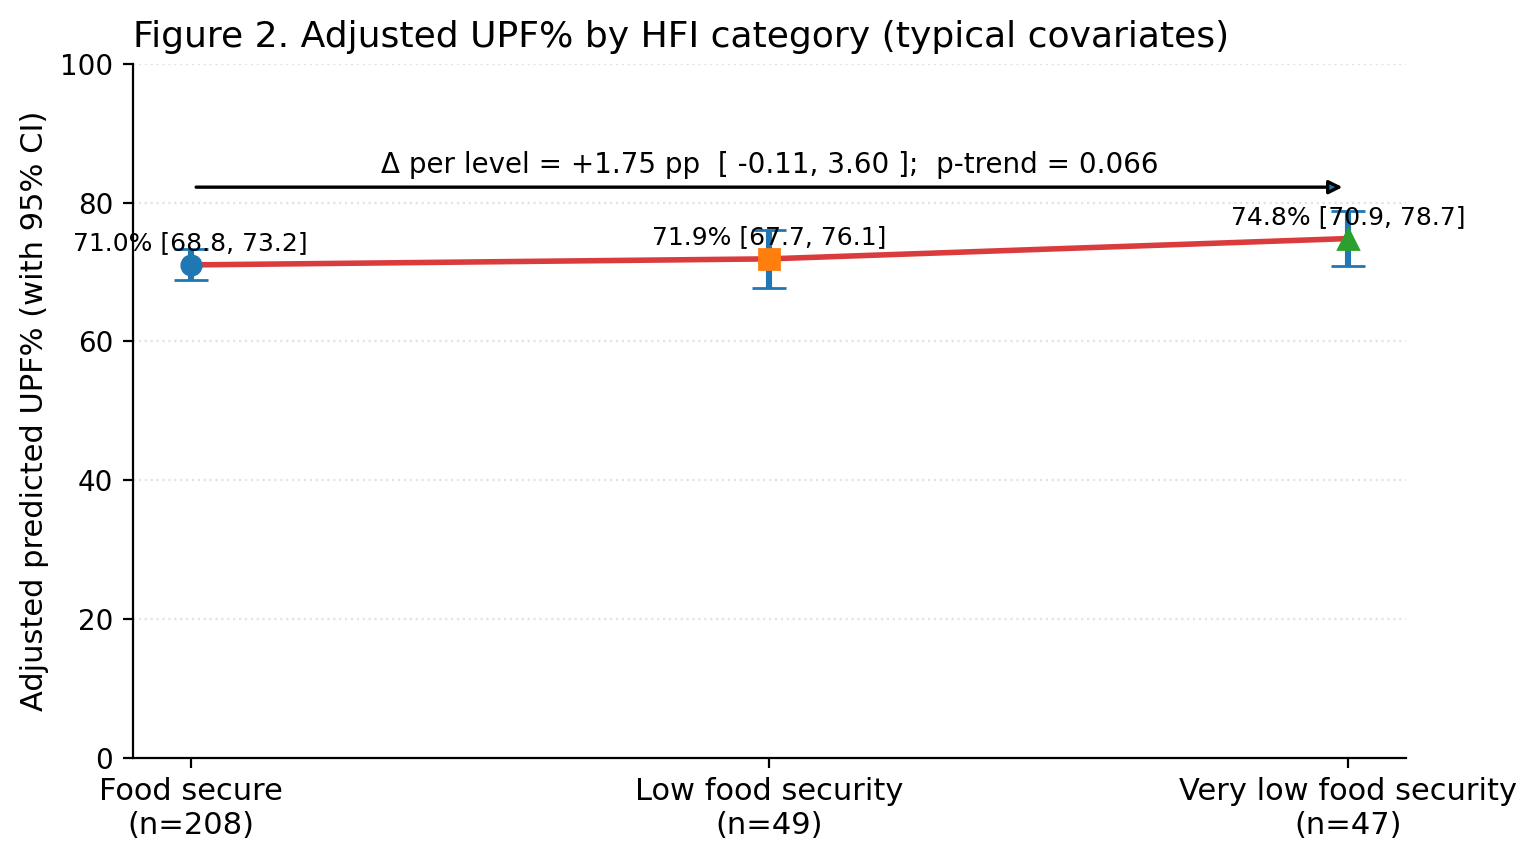

In [51]:
# === Figure 2 (polished): Adjusted UPF% by HFI category + trend arrow ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

# 1) 数据与模型（与主文一致）
cats = ["Food secure","Low food security","Very low food security"]
df_model["HFI_category"] = df_model["HFI_category"].astype(
    CategoricalDtype(categories=cats, ordered=True)
)

sens_cols = [OUTCOME, "age_participant","gender_participant",
             "ethn_participant","child_numbers","HFI_category"]
dat_sens = df_model[sens_cols].copy()
for col in ["age_participant","child_numbers"]:
    dat_sens[col] = pd.to_numeric(dat_sens[col], errors="coerce")
dat_sens = dat_sens.dropna().copy()

form_cat = (
    f"{OUTCOME} ~ C(HFI_category, Treatment(reference='Food secure'))"
    " + age_participant + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White')) + child_numbers"
)
res_cat = fit_ols(form_cat, dat_sens, cov_type="HC3")

# 2) 典型协变量预测
grid = pd.DataFrame({
    "HFI_category": cats,
    "age_participant": dat_sens["age_participant"].mean(),
    "gender_participant": 1,
    "ethn_participant": "White",
    "child_numbers": dat_sens["child_numbers"].mean(),
})
pred  = res_cat.get_prediction(grid).summary_frame(alpha=0.05)
means = pred["mean"].to_numpy(float)
lo    = pred["mean_ci_lower"].to_numpy(float)
hi    = pred["mean_ci_upper"].to_numpy(float)
yerr  = np.vstack([means - lo, hi - means])
n_by  = dat_sens["HFI_category"].value_counts().reindex(cats, fill_value=0).astype(int)

# 3) 趋势（0/1/2）
tr_map = {"Food secure":0, "Low food security":1, "Very low food security":2}
dat_sens["HFI_trend"] = dat_sens["HFI_category"].map(tr_map).astype(float)
res_trend = fit_ols(
    f"{OUTCOME} ~ HFI_trend + age_participant + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White')) + child_numbers",
    dat_sens, cov_type="HC3"
)
slope, (slo, shi), p_trend = coef_ci(res_trend, "HFI_trend")

# 4) 画图（优化样式）
plt.rcParams.update({"axes.titlesize":13,"axes.labelsize":11,"xtick.labelsize":11,"ytick.labelsize":10})
fig, ax = plt.subplots(figsize=(7.8, 4.4), dpi=200)
x = np.arange(len(cats))

# marker 形状区分三类（黑白也清楚）
markers = ['o','s','^']

# 误差线 + 点
ax.errorbar(x, means, yerr=yerr, fmt='none', capsize=6, elinewidth=2.2, zorder=2)
for i in range(len(cats)):
    ax.plot(x[i], means[i], markers[i], ms=7, zorder=3)

# 连接线（淡一点）
ax.plot(x, means, '-', linewidth=2.0, alpha=0.9, zorder=1)

# 网格/坐标
ax.set_ylim(0, 100)
ax.set_ylabel("Adjusted predicted UPF% (with 95% CI)")
ax.set_xticks(x, [f"{c}\n(n={n_by[c]})" for c in cats])
ax.grid(axis='y', linestyle=':', alpha=0.35)
ax.spines[['top','right']].set_visible(False)

# 数值标签（不遮挡）
for xi, m, l, h in zip(x, means, lo, hi):
    ax.text(xi, m + 1.4, f"{m:.1f}% [{l:.1f}, {h:.1f}]", ha='center', va='bottom', fontsize=9)

# 顶部趋势箭头 + 注释（更像你的图1）
y_top = max(hi) + 3.5
ax.annotate("", xy=(x[-1], y_top), xytext=(x[0], y_top),
            arrowprops=dict(arrowstyle='-|>', lw=1.2))
ax.text(np.mean(x), y_top + 1.2,
        f"Δ per level = {slope:+.2f} pp  [ {slo:.2f}, {shi:.2f} ];  p-trend = {p_trend:.3f}",
        ha='center', va='bottom', fontsize=10)

ax.set_title("Figure 2. Adjusted UPF% by HFI category (typical covariates)", loc='left')
plt.tight_layout()
plt.show()


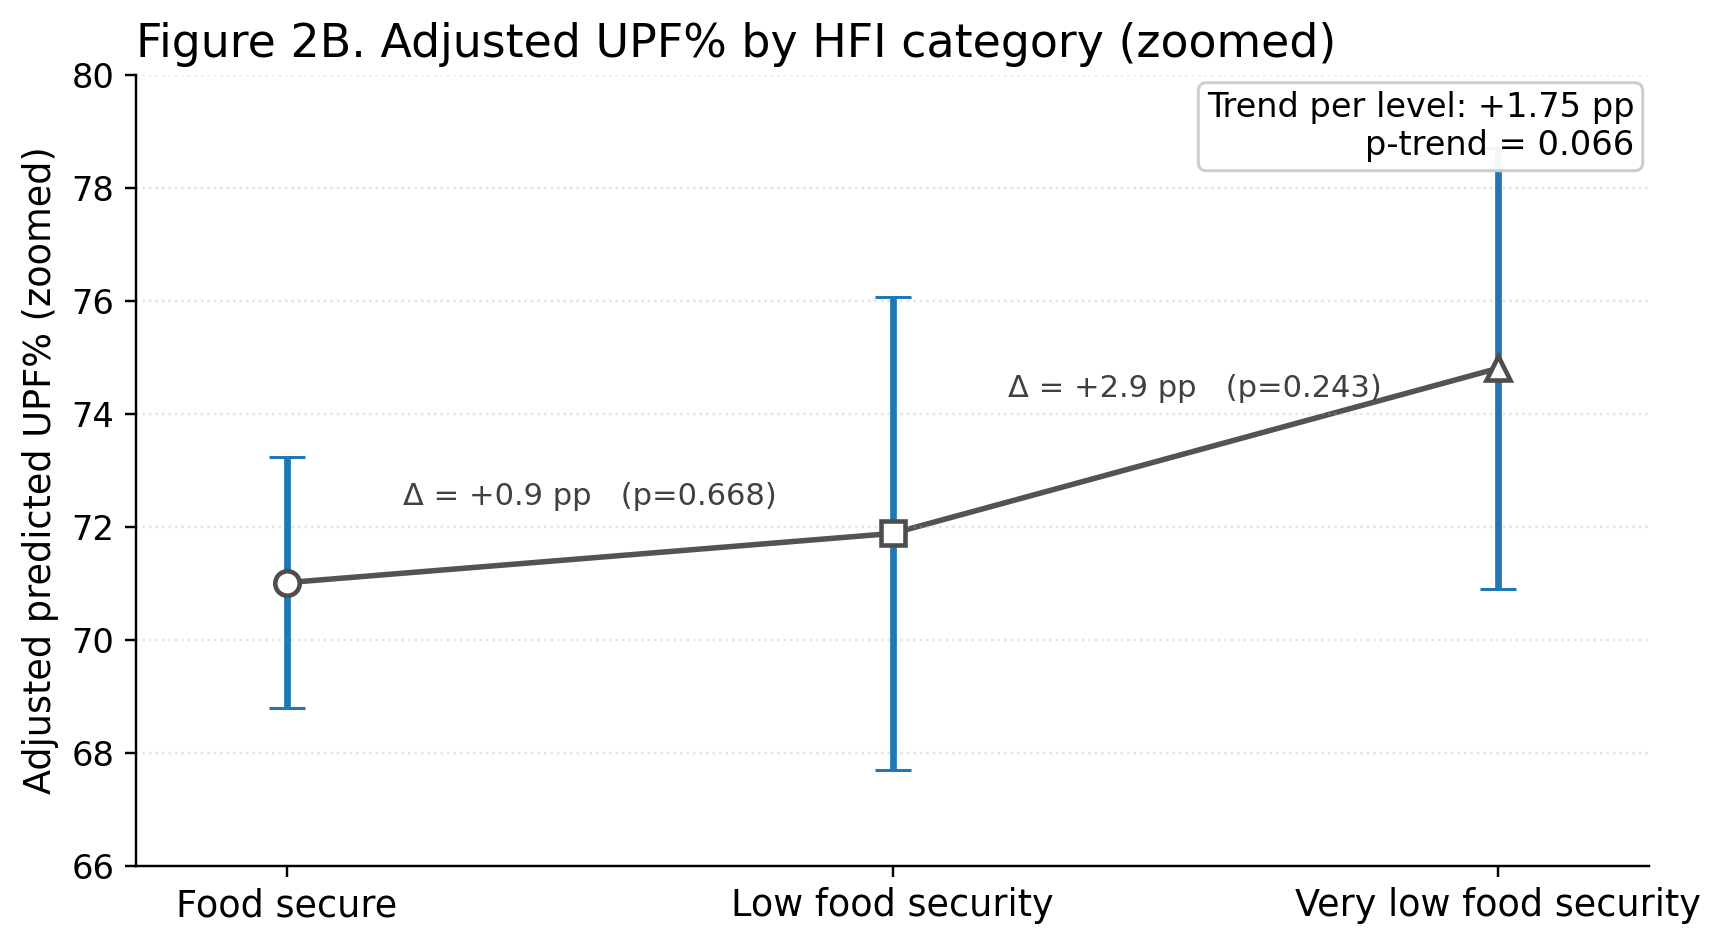

In [54]:
# === Figure 2B (clean zoom + pairwise tests) — 单段可用 ===
import numpy as np, matplotlib.pyplot as plt

# ----- 1) 成对对比：用于相邻两档的 Δ 的 p/CI -----
# 名称要与 form_cat 保持一致（Food secure 为参考）
tL = "C(HFI_category, Treatment(reference='Food secure'))[T.Low food security]"
tV = "C(HFI_category, Treatment(reference='Food secure'))[T.Very low food security]"

# Food secure→Low
est_LF, ci_LF, p_LF = linear_combo(res_cat, {tL: 1})
# Low→Very low（= Very low − Low）
est_VL, ci_VL, p_VL = linear_combo(res_cat, {tV: 1, tL: -1})

pair_info = {(0,1): {"p": p_LF, "ci": ci_LF}, (1,2): {"p": p_VL, "ci": ci_VL}}
def stars(p): return "***" if p<0.001 else "**" if p<0.01 else "*" if p<0.05 else ""

# ----- 2) 画图（极简放大版）-----
x = np.arange(len(cats))
markers = ['o','s','^']  # 圆/方/三角，黑白友好
mfc, mec = 'white', '0.3'

# 自动确定“局部”y 轴范围（把三组 CI 包住）
yl = max(0,  np.floor(min(lo) - 1.0))
yh = min(100, np.ceil (max(hi) + 1.0))

plt.rcParams.update({"figure.dpi":220,"axes.titlesize":15,"axes.labelsize":12,
                     "xtick.labelsize":12,"ytick.labelsize":11})
fig, ax = plt.subplots(figsize=(8.0, 4.4))

# 误差线 + 点 + 细连线
ax.errorbar(x, means, yerr=yerr, fmt='none', capsize=6, elinewidth=2.2, zorder=2)
for i in range(len(cats)):
    ax.plot(x[i], means[i], markers[i], ms=8, mfc=mfc, mec=mec, mew=1.5, zorder=3)
ax.plot(x, means, '-', lw=1.8, color='0.25', alpha=0.9, zorder=1)

# 轴样式
ax.set_ylim(yl, yh); ax.set_xlim(-0.25, len(cats)-0.75)
ax.set_ylabel("Adjusted predicted UPF% (zoomed)")
ax.set_xticks(x, cats)
ax.grid(axis='y', linestyle=':', alpha=0.35)
ax.spines[['top','right']].set_visible(False)

# Δ 标注（含 p 值与星号；需要 CI 就把 show_ci=True）
show_ci = False
gap = (yh - yl) * 0.06
for i in (0,1):
    midx = (x[i] + x[i+1]) / 2
    midy = (means[i] + means[i+1]) / 2 + gap
    delta = means[i+1] - means[i]
    info  = pair_info[(i, i+1)]
    label = (f"Δ = {delta:+.1f} pp  {stars(info['p'])} (p={info['p']:.3f})"
             if not show_ci else
             f"Δ = {delta:+.1f} pp  {stars(info['p'])}\n(95%CI {info['ci'][0]:.2f}, {info['ci'][1]:.2f}; p={info['p']:.3f})")
    ax.text(midx, midy, label, ha='center', va='bottom', fontsize=10, color='0.25')

# 右上角趋势徽标
ax.text(0.99, 0.98, f"Trend per level: {slope:+.2f} pp\np-trend = {p_trend:.3f}",
        transform=ax.transAxes, ha='right', va='top', fontsize=11,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.95))

ax.set_title("Figure 2B. Adjusted UPF% by HFI category (zoomed)", loc='left')
plt.tight_layout(); plt.show()


## 5.2 探索性交互：HFI × I(child_numbers≥3) （附录）

In [30]:
# ===== Exploratory interaction: HFI × I(child_numbers ≥ 3) — print only =====
import numpy as np, pandas as pd

# 1) 构造二元指示变量
df_model["many_children"] = (pd.to_numeric(df_model["child_numbers"], errors="coerce") >= 3).astype("int")

cols_c3 = [OUTCOME, "HFI_binary", "age_participant",
           "gender_participant", "ethn_participant", "child_numbers", "many_children"]

dat_c3 = df_model[cols_c3].copy()
# 强制为数值（以免混入字符串）
for c in ["HFI_binary","age_participant","child_numbers","many_children"]:
    dat_c3[c] = pd.to_numeric(dat_c3[c], errors="coerce")
dat_c3 = dat_c3.dropna().copy()

print(f"N (for children interaction): {len(dat_c3)}")

# 2) 设定模型：含主效应 + 交互
form_c3 = (
    f"{OUTCOME} ~ HFI_binary + many_children + HFI_binary:many_children"
    " + age_participant + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)
# 说明：同时加入“child_numbers(连续)” 与 “many_children(阈值)” 是在检验
# “≥3 的额外阈值效应”，many_children 可以理解为相对线性项的偏离。

res_c3 = fit_ols(form_c3, dat_c3, cov_type="HC3")

# 3) 交互系数（差异的差异）
e_int, ci_int, p_int = coef_ci(res_c3, "HFI_binary:many_children")
print(f"[交互项] HFI × I(≥3 children) = {e_int:+.2f} pp  (95%CI {ci_int[0]:.2f}, {ci_int[1]:.2f}); p={p_int:.3f}")

# 4) 简单斜率：<3 与 ≥3 的 HFI 效应
def simple_slope(many):
    combo = {"HFI_binary": 1.0}
    if many == 1:
        combo["HFI_binary:many_children"] = 1.0
    return linear_combo(res_c3, combo)  # (est, (lo,hi), p)

rows = []
lab_map = {0:"< 3 children", 1:"≥ 3 children"}
for g in [0,1]:
    est, ci, p = simple_slope(g)
    rows.append({"group": lab_map[g], "d": est, "lo": ci[0], "hi": ci[1], "p": p})

effects_ch = pd.DataFrame(rows)

# 5) 各组样本量
n_by = dat_c3.groupby("many_children")["HFI_binary"].size()
effects_ch["n"] = effects_ch["group"].map({lab_map[0]: int(n_by.get(0,0)),
                                           lab_map[1]: int(n_by.get(1,0))})

# 漂亮打印
print("\nHFI effect (insecure − secure) by children group:")
for r in effects_ch.itertuples():
    sig = "*" if r.p < 0.05 else ""
    print(f"  {r.group:>12}: {r.d:+.2f} pp [{r.lo:.2f}, {r.hi:.2f}]  p={r.p:.3f}{sig}")
print(f"\nOverall interaction p-value = {p_int:.3f}")

# 导出成表（论文表格/附录可用）
effects_ch.to_csv("output/children_interaction_effects.csv", index=False)
print("Saved: output/children_interaction_effects.csv")


N (for children interaction): 304
[交互项] HFI × I(≥3 children) = +0.37 pp  (95%CI -6.06, 6.79); p=0.911

HFI effect (insecure − secure) by children group:
  < 3 children: +2.26 pp [-1.69, 6.20]  p=0.263
  ≥ 3 children: +2.62 pp [-2.33, 7.57]  p=0.299

Overall interaction p-value = 0.911
Saved: output/children_interaction_effects.csv


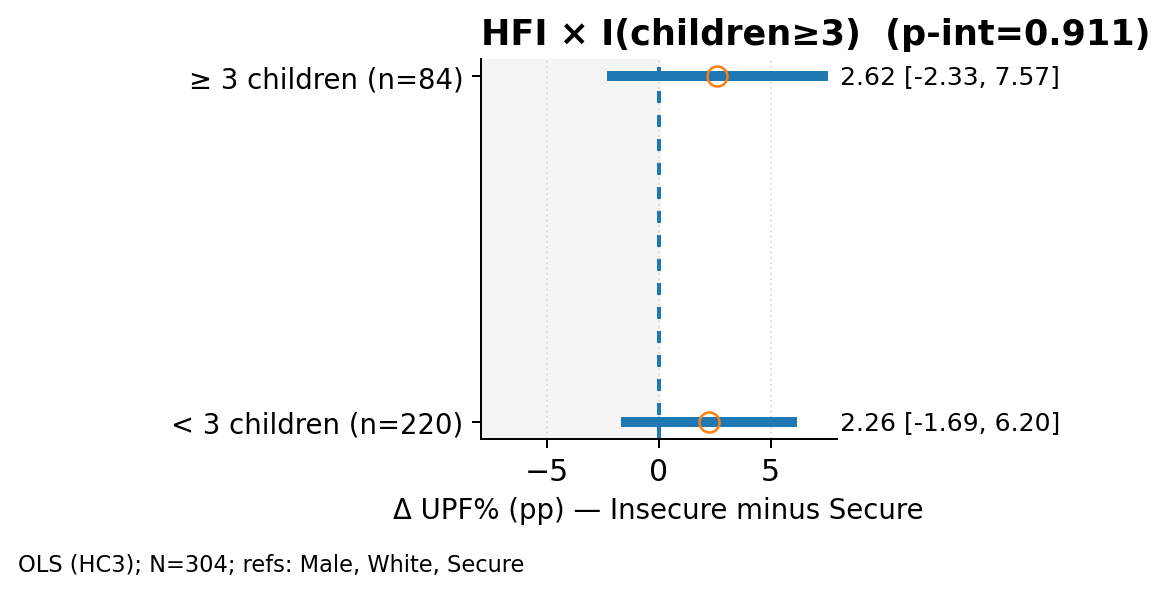

In [31]:
# ===== Figure Sx. HFI effect by children group (insecure − secure), 95% CI =====
import numpy as np, matplotlib.pyplot as plt

dfp = effects_ch.copy()
dfp["label"] = dfp.apply(lambda r: f"{r['group']} (n={int(r['n'])})", axis=1)
# 固定顺序：<3 在上，≥3 在下
order = ["< 3 children","≥ 3 children"]
dfp = dfp.set_index("group").loc[order].reset_index()

ypos = np.arange(len(dfp))
sig = dfp["p"].values < 0.05

fig_h = 2.8 + 0.35*len(dfp)
fig, ax = plt.subplots(figsize=(7.0, fig_h), dpi=180)

# 95% CI 横条
for i, (lo, hi) in enumerate(zip(dfp["lo"], dfp["hi"])):
    ax.hlines(ypos[i], xmin=lo, xmax=hi, lw=4.0, zorder=2)

# 点：显著实心、否则空心
ax.plot(dfp["d"].values[sig],  ypos[sig],  "o", ms=8, zorder=3)
ax.plot(dfp["d"].values[~sig], ypos[~sig], "o", ms=8, mfc="none", zorder=3)

# 0 线、对称范围
mx = 1.05 * max(abs(dfp["lo"].min()), abs(dfp["hi"].max()))
ax.set_xlim(-mx, mx)
ax.axvspan(-mx, 0, color="0.96", zorder=0)
ax.axvline(0, ls=(0,(3,3)), lw=1.6)

ax.set_yticks(ypos); ax.set_yticklabels(dfp["label"], fontsize=11)
ax.set_xlabel("Δ UPF% (pp) — Insecure minus Secure", fontsize=11)

# 右侧数值
def stars(pv): return "***" if pv<1e-3 else "**" if pv<1e-2 else "*" if pv<0.05 else ""
for yi, r in enumerate(dfp.itertuples()):
    ax.text(1.01, yi, f"{r.d:.2f} [{r.lo:.2f}, {r.hi:.2f}] {stars(r.p)}",
            transform=ax.get_yaxis_transform(), ha="left", va="center", fontsize=10)

ax.set_title(f"HFI × I(children≥3)  (p-int={p_int:.3f})",
             loc="left", fontsize=14, weight="bold", pad=6)
fig.text(0.12, 0.02, f"OLS (HC3); N={len(dat_c3)}; refs: Male, White, Secure",
         ha="left", va="bottom", fontsize=9)

ax.grid(axis='x', ls=':', alpha=0.35)
ax.spines[['top','right']].set_visible(False)
plt.tight_layout(rect=[0.22, 0.06, 0.98, 0.95])
# 若需要保存：
import pathlib; pathlib.Path("output").mkdir(exist_ok=True)
plt.savefig("output/children_interaction_forest.png", dpi=300, bbox_inches="tight")
plt.show()


## 5.4 年龄每 +1SD 的效应

In [32]:
# === Refit age(+1 SD) model, self-contained ===
import numpy as np, pandas as pd

# 构建同 Core-A 的自变量集合
cols = [OUTCOME, "HFI_binary", "age_participant",
        "gender_participant", "ethn_participant", "child_numbers"]
dat_ageSD = df_model[cols].copy()

# 强制转数值，并把年龄限制在 3–11（数据字典口径）
for c in ["HFI_binary","age_participant","child_numbers"]:
    dat_ageSD[c] = pd.to_numeric(dat_ageSD[c], errors="coerce")
dat_ageSD.loc[~dat_ageSD["age_participant"].between(3, 11), "age_participant"] = np.nan
dat_ageSD = dat_ageSD.dropna().copy()

# 标准化年龄 z_age（按样本均值/SD）
sd_age = dat_ageSD["age_participant"].std()
mu_age = dat_ageSD["age_participant"].mean()
dat_ageSD["z_age"] = (dat_ageSD["age_participant"] - mu_age) / sd_age

form_ageSD = (
    f"{OUTCOME} ~ HFI_binary + z_age"
    " + C(gender_participant, Treatment(reference=1))"
    " + C(ethn_participant, Treatment(reference='White'))"
    " + child_numbers"
)
res_ageSD = fit_ols(form_ageSD, dat_ageSD, cov_type="HC3")

age_sd_est, age_sd_ci, age_sd_p = coef_ci(res_ageSD, "z_age")
print(f"年龄每 +1SD（SD={sd_age:.2f} 岁）UPF% 变化 = {age_sd_est:.2f} pp "
      f"(95%CI {age_sd_ci[0]:.2f}, {age_sd_ci[1]:.2f}), p={age_sd_p:.3f}; N={len(dat_ageSD)}")


年龄每 +1SD（SD=2.59 岁）UPF% 变化 = 1.28 pp (95%CI -0.04, 2.61), p=0.059; N=304


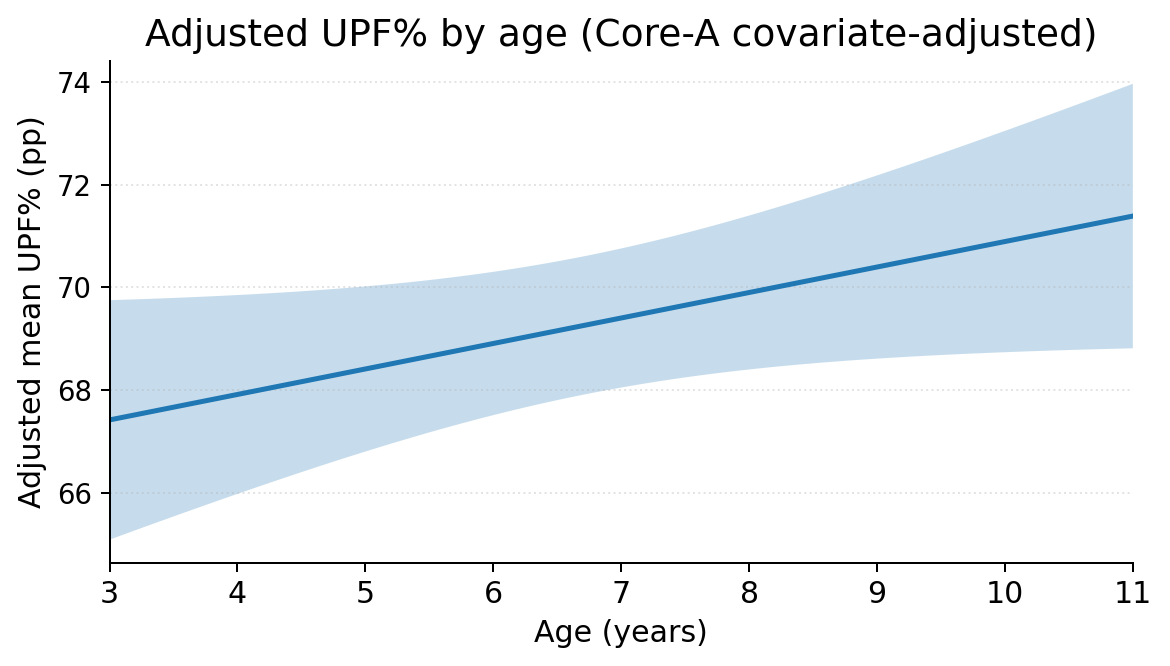

<Figure size 1408x1056 with 0 Axes>

In [33]:
# === Figure S?. Adjusted mean UPF% across age (with 95% CI) ===
import numpy as np, matplotlib.pyplot as plt

# 年龄网格（按数据/字典范围）
age_min = max(3.0, float(dat_ageSD["age_participant"].min()))
age_max = min(11.0, float(dat_ageSD["age_participant"].max()))
age_grid = np.linspace(age_min, age_max, 120)

# 从模型取设计矩阵与参数
X      = np.asarray(res_ageSD.model.exog)
names  = list(res_ageSD.model.exog_names)
i_age  = names.index("z_age")
beta   = np.asarray(res_ageSD.params)
covB   = np.asarray(res_ageSD.cov_params())
zstar  = _zcrit(0.05)

means, los, his = [], [], []
for a in age_grid:
    z = (a - mu_age) / sd_age            # 把年龄点换成 z_age
    Xtmp = X.copy()
    Xtmp[:, i_age] = z                   # 仅替换年龄列，其它协变量保持样本原值
    xbar = Xtmp.mean(axis=0)             # 平均预测 = 平均设计行 × beta
    mu  = float(xbar @ beta)
    var = float(xbar @ covB @ xbar)
    se  = np.sqrt(max(var, 0.0))
    means.append(mu); los.append(mu - zstar*se); his.append(mu + zstar*se)

means, los, his = map(np.asarray, (means, los, his))

fig, ax = plt.subplots(figsize=(6.6, 3.8), dpi=180)
ax.plot(age_grid, means, lw=2)
ax.fill_between(age_grid, los, his, alpha=0.25)
ax.set_xlim(age_min, age_max)
ax.set_xlabel("Age (years)")
ax.set_ylabel("Adjusted mean UPF% (pp)")
ax.set_title("Adjusted UPF% by age (Core-A covariate-adjusted)")
ax.grid(axis='y', ls=':', alpha=0.35)
ax.spines[['top','right']].set_visible(False)
plt.tight_layout()
plt.show()

#保存
import pathlib; pathlib.Path("output").mkdir(exist_ok=True)
plt.savefig("output/figureS4_age_effect.png", dpi=300, bbox_inches="tight")

# 6. Table 1（描述性摘要）

In [34]:
# ===== Final Table 1 helper =====
import numpy as np, pandas as pd

def table1(df,
           outcome=OUTCOME,
           listwise=False,
           gender_map={1:"Male", 2:"Female", 3:"Other"},
           ethn_order=("White","Asian","All other ethnicities"),
           digits=2):
    """
    df:   数据框（建议传 dat_coreA；或 df_model[coreA_cols] 并设 listwise=True）
    outcome: 结局变量名（默认 OUTCOME）
    listwise: True 时先对 table1 所需列做 listwise 删除（与 Core-A 样本一致）
    """
    d = df.copy()

    # --- 需要用到的列 ---
    needed = [outcome, "age_participant", "gender_participant",
              "ethn_participant", "child_numbers", "HFI_binary"]
    needed = [c for c in needed if c in d.columns]
    # 强制数值
    for c in ("age_participant","child_numbers","HFI_binary", outcome):
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")
    if listwise:
        d = d[needed].dropna().copy()

    # --- 小工具 ---
    def fmt_mean_sd(s):
        return f"{s.mean():.{digits}f} ± {s.std():.{digits}f}"
    def fmt_med_iqr(s):
        q1, q3 = s.quantile([.25,.75])
        return f"{s.median():.{digits}f} [{q1:.{digits}f}, {q3:.{digits}f}]"
    def add_cat_block(series, title, order=None, mapper=None):
        out_rows = []
        s = series.copy()
        if mapper:
            s = s.map(lambda x: mapper.get(x, mapper.get(int(x), x)) if pd.notna(x) else x)
        counts = s.value_counts(dropna=False)
        if order is not None:
            # 先按 order，再拼上其它与缺失
            idx = [k for k in order if k in counts.index]
            rest = [k for k in counts.index if k not in idx and pd.notna(k)]
            idx = idx + rest
            if counts.index.isna().any(): idx += [np.nan]
            counts = counts.reindex(idx)
        n = int(s.notna().sum())
        for k, v in counts.items():
            label = "Missing" if pd.isna(k) else str(k)
            pct = v / len(s) * 100
            out_rows.append((f"{title}: {label}", f"{int(v)} ({pct:.1f}%)"))
        return out_rows

    rows = []

    # 样本量
    rows.append(("N", f"{len(d)}"))

    # 年龄
    if "age_participant" in d:
        s = d["age_participant"].dropna()
        rows.append(("Age (years), mean ± SD", fmt_mean_sd(s)))
        rows.append(("Age (years), median [IQR]", fmt_med_iqr(s)))

    # 家庭儿童数（可选）
    if "child_numbers" in d:
        s = d["child_numbers"].dropna()
        rows.append(("Children in household, median [IQR]", fmt_med_iqr(s)))

    # 性别
    if "gender_participant" in d:
        rows += add_cat_block(d["gender_participant"], "Gender",
                              order=[gender_map.get(1,"Male"), gender_map.get(2,"Female"), gender_map.get(3,"Other")],
                              mapper=gender_map)

    # 族裔（固定三类顺序）
    if "ethn_participant" in d:
        rows += add_cat_block(d["ethn_participant"], "Ethnicity",
                              order=list(ethn_order))

    # HFI 流行率（不安全=1）
    if "HFI_binary" in d:
        k = int(d["HFI_binary"].sum(skipna=True))
        n = int(d["HFI_binary"].notna().sum())
        rows.append(("HFI insecure, n (%)", f"{k} ({k/n*100:.1f}%)"))

    # 结局总体均值
    if outcome in d:
        s = d[outcome].dropna()
        rows.append((f"{outcome} — mean ± SD (pp)", fmt_mean_sd(s)))

    # 各族裔的 UPF% 原始均值（附 n）
    if outcome in d and "ethn_participant" in d:
        g = d.groupby("ethn_participant", dropna=False)
        mean_by = g[outcome].mean()
        n_by    = g[outcome].size()
        for k in list(ethn_order):
            if k in mean_by.index:
                rows.append((f"UPF% mean — {k}", f"{mean_by[k]:.{digits}f} (n={int(n_by[k])})"))
        # 若有缺失类别也写上
        if mean_by.index.isna().any():
            k = np.nan
            rows.append(("UPF% mean — Missing", f"{mean_by[k]:.{digits}f} (n={int(n_by[k])})"))

    out_df = pd.DataFrame(rows, columns=["Characteristic", "Value"]).set_index("Characteristic")
    return out_df


In [35]:
# 1) 与 Core-A 完全同样本（推荐）
t1_df = table1(dat_coreA, listwise=False)

# 2) 直接从原数据抽列并做 listwise（如果没有 dat_coreA）
# t1_df = table1(df_model[coreA_cols], listwise=True)

print("\nTable 1（主样本，含三类族裔）:")
display(t1_df)

# 导出
import pathlib; pathlib.Path("output").mkdir(exist_ok=True)
t1_df.to_csv("output/table1_coreA.csv")



Table 1（主样本，含三类族裔）:


/tmp/ipython-input-3440823261.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = d.groupby("ethn_participant", dropna=False)


,Value
Characteristic,
N,304
"Age (years), mean ± SD",6.88 ± 2.59
"Age (years), median [IQR]","7.00 [5.00, 9.00]"
"Children in household, median [IQR]","2.00 [2.00, 3.00]"
Gender: Male,156 (51.3%)
Gender: Female,148 (48.7%)
Ethnicity: White,167 (54.9%)
Ethnicity: Asian,99 (32.6%)
Ethnicity: All other ethnicities,38 (12.5%)
